# **Finding Lane Lines on the Road** 

- Manoj Pandey
- Akul Mehra
- Ashu Goel
- Harsh Nandan
***
In this project, we will write algorithm to identify lane lines on the road.  First we develop our pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). 

Dataset we are using is provided by Udacity.


---
<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Intermediate output after detecting line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Target goal</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pylab import savefig
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


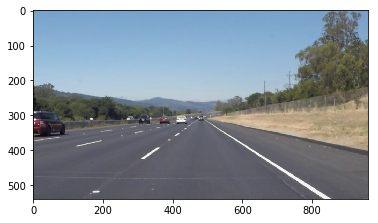

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
   
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def draw_lines_extrapolate(img, lines, color=[255, 0, 0], thickness=10):
    # Assume lines on left and right have opposite signed slopes
    lines_left = []
    lines_right = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 - x1 == 0: continue; # Infinite slope
            slope = float(y2-y1)/float(x2-x1)
            if abs(slope) < .5 or abs(slope) > .9: continue # Discard unlikely slopes
            if slope > 0: 
                lines_left += [(x1,y1),(x2,y2)]
            else: 
                lines_right += [(x1,y1),(x2,y2)]

    left_xs = map(lambda x: x[0], lines_left)
    left_ys = map(lambda x: x[1], lines_left)
    right_xs = map(lambda x: x[0], lines_right)
    right_ys = map(lambda x: x[1], lines_right)
    
    left_fit = np.polyfit(list(left_xs), list(left_ys), 1)
    right_fit = np.polyfit(list(right_xs), list(right_ys), 1)
    
    y1 = img.shape[0] # Bottom of image
    y2 = img.shape[0] / 2+ 50 # Middle of view
    x1_left = (y1 - left_fit[1]) / left_fit[0]
    x2_left = (y2 - left_fit[1]) / left_fit[0]
    x1_right = (y1 - right_fit[1]) / right_fit[0]
    x2_right = (y2 - right_fit[1]) / right_fit[0]    
    y1 = int(y1); y2 = int(y2);
    x1_left = int(x1_left); x2_left = int(x2_left);
    x1_right = int(x1_right); x2_right = int(x2_right);

    cv2.line(img, (x1_left, y1), (x2_left, y2), color, thickness)
    cv2.line(img, (x1_right, y1), (x2_right, y2), color, thickness)    

def hough_extrapolate_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
#     line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_extrapolate(line_img, lines)
    return line_img

    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now we start to build our pipeline to work on the images in the directory "test_images"  

In [4]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

We run our solution on all test_images and make copies into the test_images directory).

## Color Selection

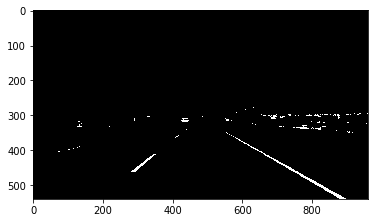

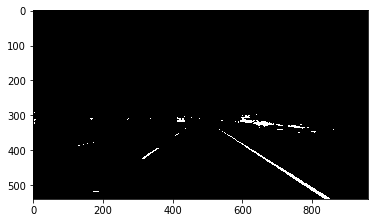

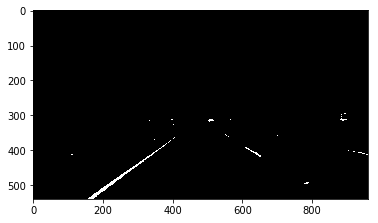

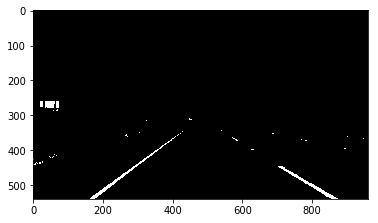

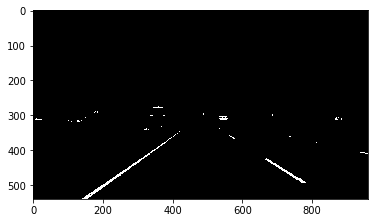

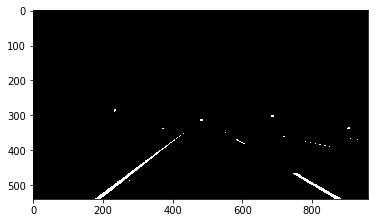

In [5]:
images = os.listdir("test_images/")
imageDir = "test_images/"
images.remove('.DS_Store')
## Color Selection

def colorSelect(img):
    color_thresholds = np.array([210,110,70])
    white_colors = np.array([255,255,255])
    return cv2.inRange(img, color_thresholds, white_colors)
    
for image in images:  
    pic = mpimg.imread(imageDir+image)
    color_select_pic = colorSelect(pic)
    plt.figure()
    plt.imshow(color_select_pic, cmap='gray')


## Filter Region of Interest

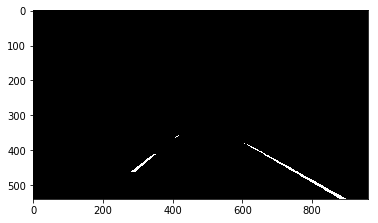

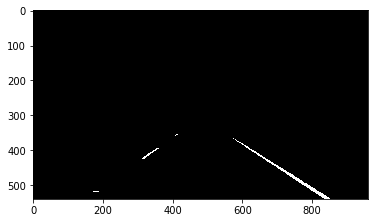

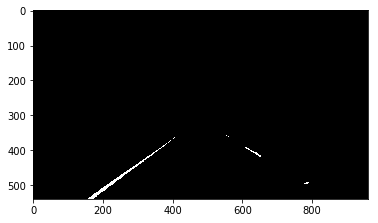

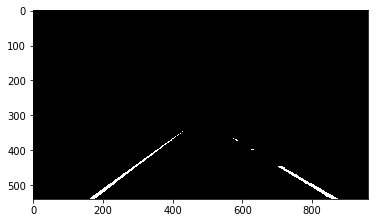

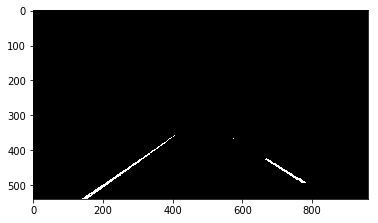

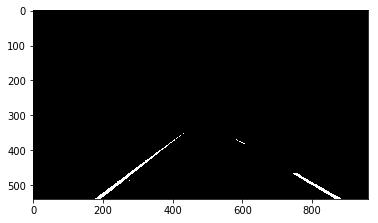

In [6]:
def ROI(img):
    y_shape = img.shape[0]
    x_shape = img.shape[1]
    vertices = np.array([[x_shape/2, y_shape*0.6], [x_shape/2, y_shape*0.6],
            [x_shape, y_shape*1], [0, y_shape*1]], dtype=np.int32)
    return region_of_interest(img, [vertices])

for image in images:  
    pic = mpimg.imread(imageDir+image)
    color_select_pic = colorSelect(pic)
    image_with_roi = ROI(color_select_pic)
    plt.figure()
    plt.imshow(image_with_roi, cmap='Greys_r')

## Applying Canny-Edge Detection

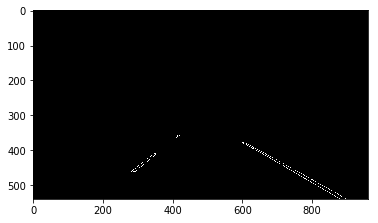

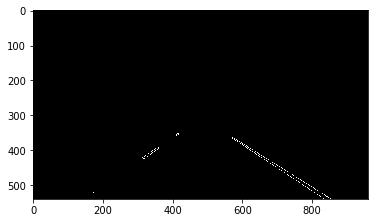

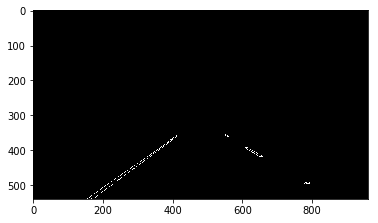

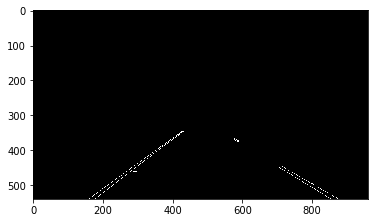

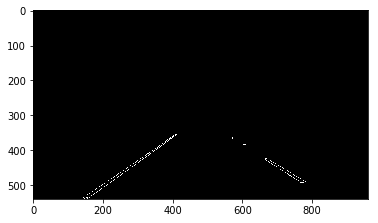

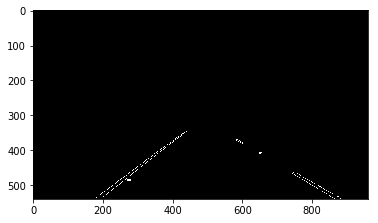

In [18]:
def removeChannels(img):
    if len(img.shape) > 2:
        img = grayscale(img)
    return img

def edge_detection(img):
    
    img = removeChannels(img)
    blur = gaussian_blur(img, 5)
    edges = canny(blur, 50, 150)
    return edges

for image in images:  
    pic = mpimg.imread(imageDir+image)
    color_select_pic = colorSelect(pic)
    image_with_roi = ROI(color_select_pic)
    edges = edge_detection(image_with_roi)
#     line_image = hough_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=40, max_line_gap=100)
    plt.figure()
    plt.imshow(edges, cmap='Greys_r')

## Applying Hough Transform

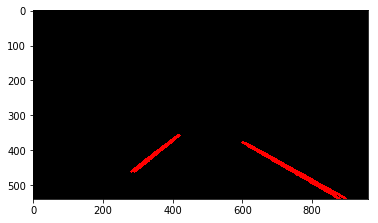

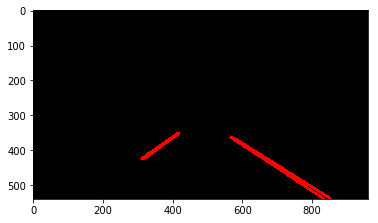

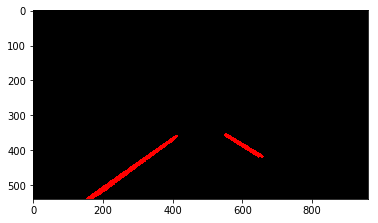

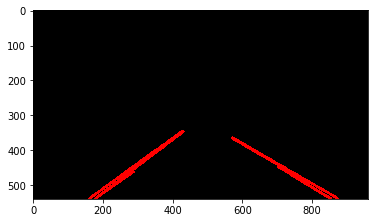

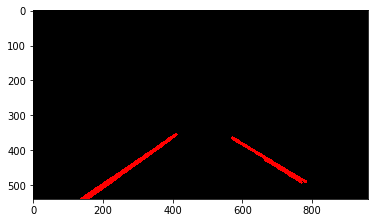

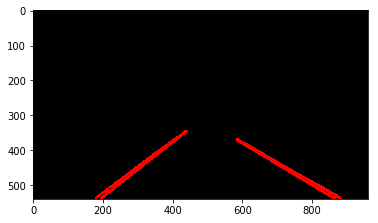

In [8]:
for image in images:  
    pic = mpimg.imread(imageDir+image)
    color_select_pic = colorSelect(pic)
    image_with_roi = ROI(color_select_pic)
    edges = edge_detection(image_with_roi)
    line_image = hough_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=40, max_line_gap=100)
    plt.figure()
    plt.imshow(line_image, cmap='Greys_r')

## PIPELINE 

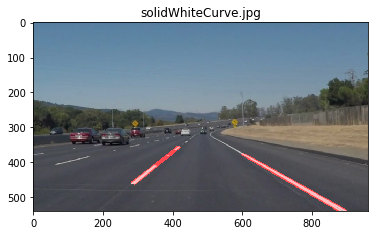

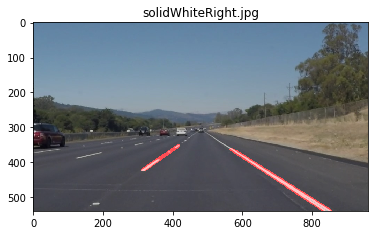

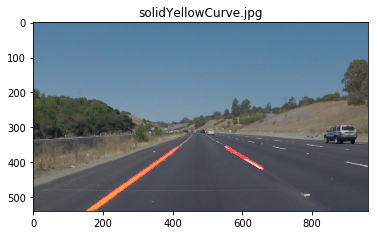

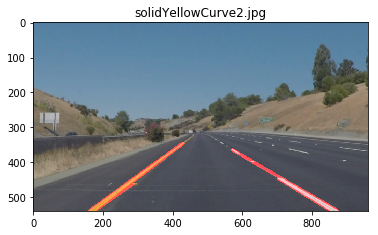

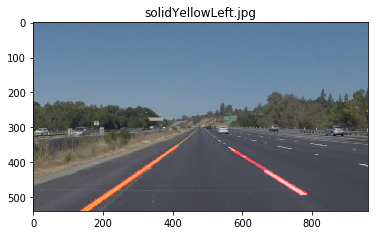

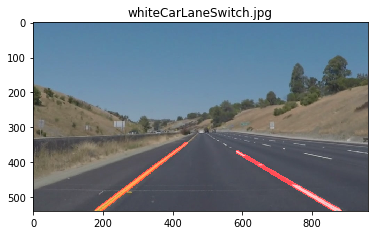

In [9]:
def pipeline_hough(img):
    
    original_image = np.copy(img)
    color_select_image = colorSelect(original_image)
    image_with_roi = ROI(color_select_image)
    edges = edge_detection(image_with_roi)
    line_image = hough_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=100, max_line_gap=100)
#     line_image = hough_extrapolate_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=100, max_line_gap=100)
    #drew_lines(line_image, lines)
    w_image = weighted_img(line_image, original_image)
    return w_image

for image in images:  
    # for image in ['solidWhiteRight.jpg']:  
    img = mpimg.imread(imageDir+image);
    lanes = pipeline_hough(img)
    plt.figure()
    plt.title(image)
    plt.imshow(lanes, cmap='Greys_r')
    split = image.split('.') 
    imgName = split[0] + '_lanes.jpg' 
#     mpimg.imsave(os.path.join('test_images', imgName), lanes)
    savefig('minor_img/6_5.jpg')

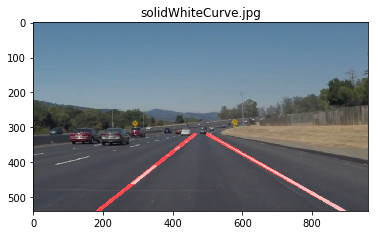

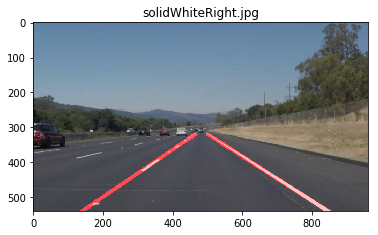

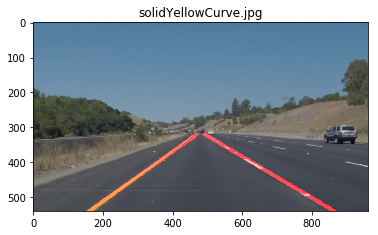

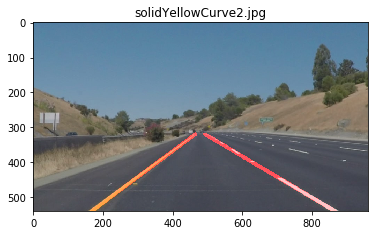

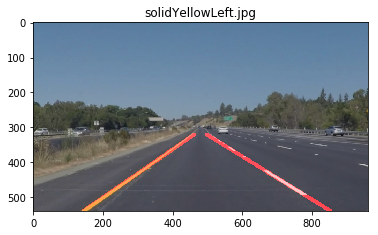

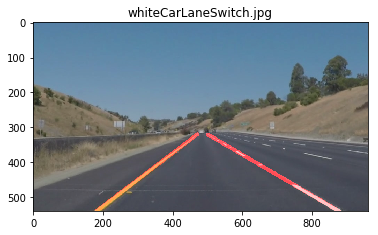

In [10]:
def pipeline_hough(img):
    
    original_image = np.copy(img)
    color_select_image = colorSelect(original_image)
    image_with_roi = ROI(color_select_image)
    edges = edge_detection(image_with_roi)
#     line_image = hough_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=100, max_line_gap=100)
    line_image = hough_extrapolate_lines(edges, rho=1, theta=np.pi/180, threshold=10, min_line_len=100, max_line_gap=100)
    #drew_lines(line_image, lines)
    w_image = weighted_img(line_image, original_image)
    return w_image

for image in images:  
#     for image in ['solidWhiteRight.jpg']:  
    img = mpimg.imread(imageDir+image);
    lanes = pipeline_hough(img)
    plt.figure()
    plt.title(image)
    plt.imshow(lanes, cmap='Greys_r')
    split = image.split('.') 
    imgName = split[0] + '_lanes.jpg' 
#     mpimg.imsave(os.path.join('test_images', imgName), lanes)
    savefig('minor_img/6_5.jpg')

# Testing with Videos

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    result = pipeline_hough(image)
    return result

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight_2.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

KeyboardInterrupt: 

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Experimenting with Vehicle Detection

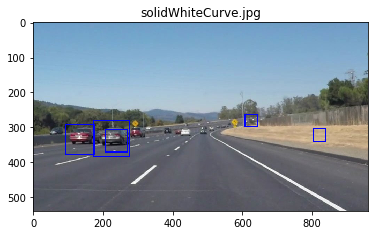

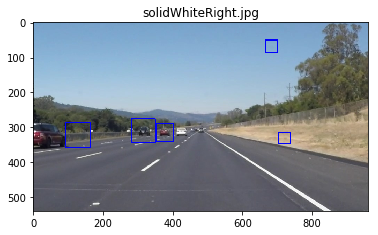

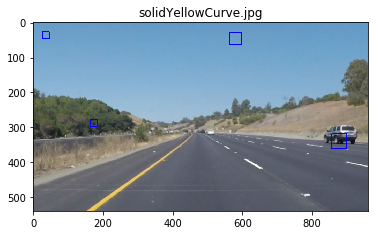

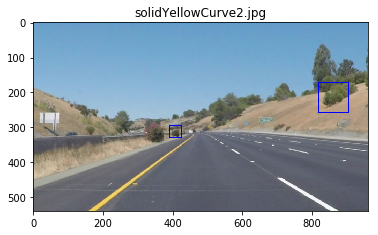

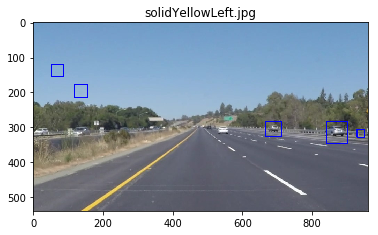

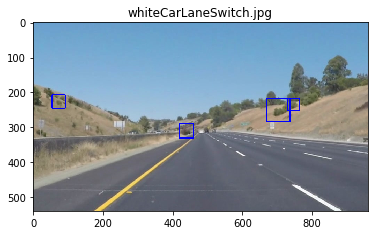

In [15]:
# Not Accurate Results, Still WIP
def process_image(image):
    car_cascade = cv2.CascadeClassifier('cars.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    cars = car_cascade.detectMultiScale(gray, 1.2, 1)

    # # To draw a rectangle in each cars
    for (x,y,w,h) in cars:
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
    result = image
    return result

for i, image in enumerate(images):  
    img = mpimg.imread(imageDir+image);
    cars = process_image(img)
    plt.figure()
    plt.title(image)
    plt.imshow(cars) 
#     mpimg.imsave(os.path.join('test_images', imgName), lanes)
    savefig('minor_img/11' + str(i) + '.jpg')